## Deep Learning
### Project 1

### Name: Thomas Saltos

### Imports

In [1]:
import math
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.0.0


### Dataset

In [2]:
batch_size = 128
classes = 10
epochs = 20

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


In [3]:
class_names = {i:cn for i, cn in enumerate(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']) }

In [4]:
def plot(images, labels, predictions=None):
    """Helper function to plot images, labels and predictions
    Parameters
    ----------
    images : 3D matrix of image
    labels : 1D array
    predictions (optional): 1D array
    """
    # create a grid with 5 columns
    n_cols = min(5, len(images))
    n_rows = math.ceil(len(images) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols+3, n_rows+4))
    
    if predictions is None:
        predictions = [None] * len(labels)
        
    for i, (x, y_true, y_pred) in enumerate(zip(images, labels, predictions)):
        ax = axes.flat[i]
        ax.imshow(x, cmap=plt.cm.binary)
        
        ax.set_title(f"{class_names[y_true]}")
        
        if y_pred is not None:
            ax.set_xlabel(f"pred: {class_names[y_pred]}")
    
        ax.set_xticks([])
        ax.set_yticks([])

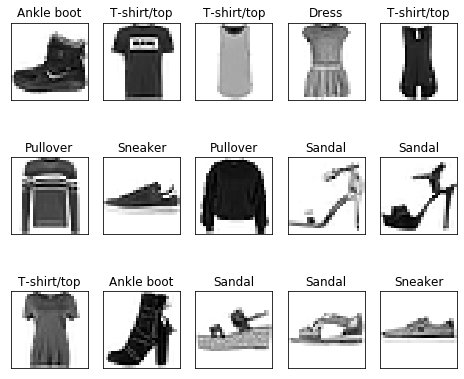

In [5]:
# plot first few images
plot(X_train[:15], y_train[:15]) 

In [6]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

### Plotting Results

In [7]:
def plot_history(history):
    print()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax2.legend()

In [8]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

### Model creation - MLP

In [9]:
def train_model(
        train_data,
        train_labels,
        optimizer,
        epochs=50,
        batch_size=128,
        hidden_layers=0,
        hidden_activation='relu',
        output_activation='softmax',
        verbose=0):
    
    np.random.seed(14) # Define the seed for numpy to have reproducible experiments.
    tf.random.set_seed(1993) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=256,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

In [10]:
# Using Adam
optimizer = Adam()

# MLP
mlp_model_adam, mlp_hs_adam = train_model(
    train_data=X_train,
    train_labels=Y_train,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_adam = mlp_model_adam.evaluate(X_test, Y_test, verbose=0)
clean_up(model=mlp_model_adam)

Finished training.
------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Hidden-1 (Dense)             (None, 256)               200960    
_________________________________________________________________
Output (Dense)               (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


Train Loss     : 0.17509
Validation Loss: 0.31366
Test Loss      : 0.32680
---
Train Accuracy     : 0.93611
Validation Accuracy: 0.89333
Test Accuracy      : 0.89110



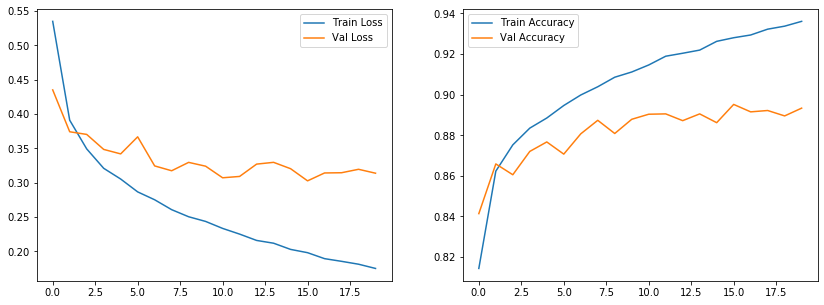

In [11]:
print("Train Loss     : {0:.5f}".format(mlp_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(history=mlp_hs_adam)

### Model creation - CNN

In [12]:
batch_size = 128
classes = 10
epochs = 100

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

In [13]:
def train_model(
        optimizer,
        epochs=50,
        batch_size=128,
        conv_layers=2,
        conv_activation='relu',
        conv_dropout=False,
        output_activation='softmax',
        callbacks=None,
        verbose=0):
    
    np.random.seed(14) # Define the seed for numpy to have reproducible experiments.
    tf.random.set_seed(1993) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

### Early stopping with patience 10

In [14]:
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping

# Using Adam
optimizer = Adam()

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# 3 Convolutional Layers and Logistic Regression
conv_drop_es_10_eval_model_adam, conv_drop_es_10_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    conv_layers=3,
    conv_activation='relu',
    conv_dropout=True,
    output_activation='softmax',
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test data and show all the results.
conv_drop_es_10_eval_adam = conv_drop_es_10_eval_model_adam.evaluate(X_test, Y_test, verbose=0)
clean_up(model=conv_drop_es_10_eval_model_adam)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 22s 404us/sample - loss: 0.8661 - accuracy: 0.6847 - val_loss: 0.5243 - val_accuracy: 0.8107
Epoch 2/100
54000/54000 [==============================] - 21s 392us/sample - loss: 0.5407 - accuracy: 0.8011 - val_loss: 0.4292 - val_accuracy: 0.8422
Epoch 3/100
54000/54000 [==============================] - 21s 393us/sample - loss: 0.4814 - accuracy: 0.8249 - val_loss: 0.4017 - val_accuracy: 0.8515
Epoch 4/100
54000/54000 [==============================] - 21s 397us/sample - loss: 0.4462 - accuracy: 0.8371 - val_loss: 0.3728 - val_accuracy: 0.8675
Epoch 5/100
54000/54000 [==============================] - 21s 393us/sample - loss: 0.4228 - accuracy: 0.8454 - val_loss: 0.3565 - val_accuracy: 0.8693
Epoch 6/100
54000/54000 [==============================] - 21s 388us/sample - loss: 0.4062 - accuracy: 0.8533 - val_loss: 0.3471 - val_accuracy: 0.8745
Epoch 7/100
54000/54000 [==============

54000/54000 [==============================] - 22s 401us/sample - loss: 0.2747 - accuracy: 0.8981 - val_loss: 0.2427 - val_accuracy: 0.9115
Epoch 55/100
54000/54000 [==============================] - 22s 409us/sample - loss: 0.2755 - accuracy: 0.8979 - val_loss: 0.2428 - val_accuracy: 0.9083
Epoch 56/100
54000/54000 [==============================] - 22s 407us/sample - loss: 0.2773 - accuracy: 0.8979 - val_loss: 0.2419 - val_accuracy: 0.9100
Epoch 57/100
54000/54000 [==============================] - 23s 422us/sample - loss: 0.2711 - accuracy: 0.9004 - val_loss: 0.2340 - val_accuracy: 0.9133
Epoch 58/100
54000/54000 [==============================] - 22s 411us/sample - loss: 0.2699 - accuracy: 0.9008 - val_loss: 0.2353 - val_accuracy: 0.9127
Epoch 59/100
54000/54000 [==============================] - 22s 402us/sample - loss: 0.2708 - accuracy: 0.9001 - val_loss: 0.2423 - val_accuracy: 0.9103
Epoch 60/100
54000/54000 [==============================] - 23s 418us/sample - loss: 0.2706 - a

Train Loss     : 0.27084
Validation Loss: 0.23408
Test Loss      : 0.24525
---
Train Accuracy     : 0.90081
Validation Accuracy: 0.91200
Test Accuracy      : 0.91220



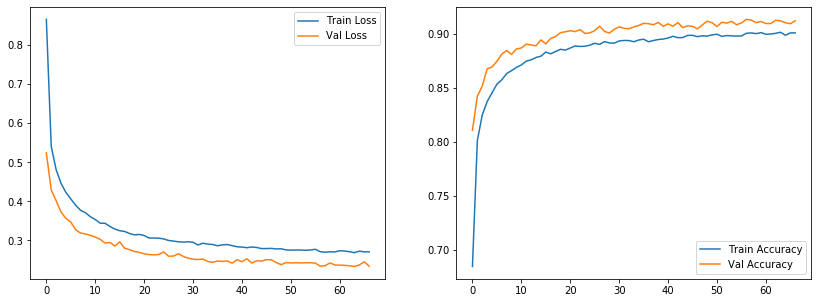

In [15]:
print("Train Loss     : {0:.5f}".format(conv_drop_es_10_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_drop_es_10_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_drop_es_10_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_drop_es_10_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_drop_es_10_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_drop_es_10_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(history=conv_drop_es_10_hs_adam)